In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [4]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv10_F11/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw10_F11/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw10_F11/plots_meas'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [6]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [7]:
# measurement data  - need to be divided by (4*np.pi)
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'dvar')
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
dvar_meas = pd.read_hdf(meas_datafile,'param')

qoi_meas = pd.read_hdf(meas_datafile,'qoi')

qoi_meas



F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.898133     9.812126     9.780692     9.713143  ...   
1     294.33823   274.810342   273.276961   267.670406    256.42997  ...   
2     138.89772   147.105122    133.24079   114.931483   109.322211  ...   
3     181.56351   157.498141    131.03587   101.940804    72.543582  ...   
4     119.35442    71.961964    57.870742    49.497148    41.000065  ...   
5     11.484595    11.318596    11.203328    11.143059    11.132492  ...   
6     29.841686    29.746688     29.56951    29.268835    28.897714  ...   
7     72.211281    65.265902    64.064075    63.030589    62.087433  ...   
8      149.0925   139.418343   136.915128   135.413765   133.908431  ...   
9     119.41093   114.638491   112.756318    110.20757   107.400512  ...   
10    237.04869    213.72616    209.10027   206.119219   200.170367  ...   
11    171.20494   158.477975   153.810887   146.616963   139.183722  ...   
12    315.74103   292.228769   284.521563   260.474723    240.43224  ...   
13    99.863449    94.076989    90.692855    81.414035    68.016267  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.061826      0.057134      0.052089      0.040751      0.040911   
1      -0.441232     -0.401337     -0.368562     -0.334364     -0.309479   
2      -0.741377     -0.693725     -0.681174     -0.632558     -0.602007   
3      -0.575589     -0.536714     -0.507962     -0.553993     -0.525728   
4      -0.523141      -0.50454     -0.472679     -0.416469     -0.317612   
5       0.081484      0.078445      0.070497       0.06563      0.061137   
6       0.152212      0.129584      0.104234      0.093521      0.085057   
7      -0.066784     -0.085836     -0.094277     -0.059041     -0.053655   
8       0.020547      0.022647      0.022047      0.016791       0.03127   
9       0.250642      0.212366      0.177127      0.172673      0.174824   
10     -0.093295     -0.077207     -0.074237     -0.087953     -0.076371   
11      0.002308      0.013184      0.001364      -0.03792     -0.012979   
12      0.136368      0.122509      0.104022      0.090523      0.108632   
13      0.055255     -0.011847     -0.014415      0.085851     -0.048677   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

In [8]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
#qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

#qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
#qoi_meas_preprocessed


meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
qoi_meas_preprocessed

F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.907636     9.838376     9.765396     9.688802  ...   
1     294.33823    286.71097    278.78708    270.60162    262.19009  ...   
2     138.89772    134.01062    128.97156    123.80804    118.54761  ...   
3     181.56351    167.37581    153.37401    139.69453    126.46206  ...   
4     119.35442    98.925941     80.22715    63.481689    48.849827  ...   
5     11.484595    11.418749    11.349015    11.275488    11.198265  ...   
6     29.841686    29.619547    29.384605    29.137228    28.877802  ...   
7     72.211281    71.364807     70.47345    69.539268    68.564407  ...   
8      149.0925    146.91719    144.63177    142.24245    139.75555  ...   
9     119.41093    117.29861    115.08589    112.77979     110.3875  ...   
10    237.04869    231.05679     224.8233    218.37454    211.73721  ...   
11    171.20494    165.40796    159.42224    153.27936    147.01094  ...   
12    315.74103    301.44171    286.83267    272.00998    257.06799  ...   
13    99.863449    92.011734    84.233818    76.601868    69.181999  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.081034      0.072851      0.065115      0.057823      0.050974   
1      -0.442524     -0.400883     -0.360518     -0.321694     -0.284636   
2      -0.660275     -0.611036     -0.558628     -0.504535      -0.45013   
3      -0.638159     -0.609828      -0.56966     -0.521175     -0.467822   
4      -0.580507     -0.558302     -0.522558     -0.474301     -0.417153   
5       0.068454      0.061512      0.054955       0.04878      0.042984   
6       0.117186      0.105547      0.094501      0.084052      0.074205   
7      -0.167922     -0.151881     -0.136464     -0.121726     -0.107716   
8       0.011969      0.013367      0.014146      0.014395        0.0142   
9       0.192151      0.175165      0.158521      0.142335      0.126713   
10     -0.087538     -0.083462     -0.078723     -0.073427     -0.067688   
11     -0.050779     -0.041434     -0.032962     -0.025375     -0.018693   
12      0.166831      0.153275      0.139661      0.126198      0.113069   
13      0.040776       0.05445      0.071118       0.09077        0.1131   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

# Apply logarithm and other preprocessing of data

In [10]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [11]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [12]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [13]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [14]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

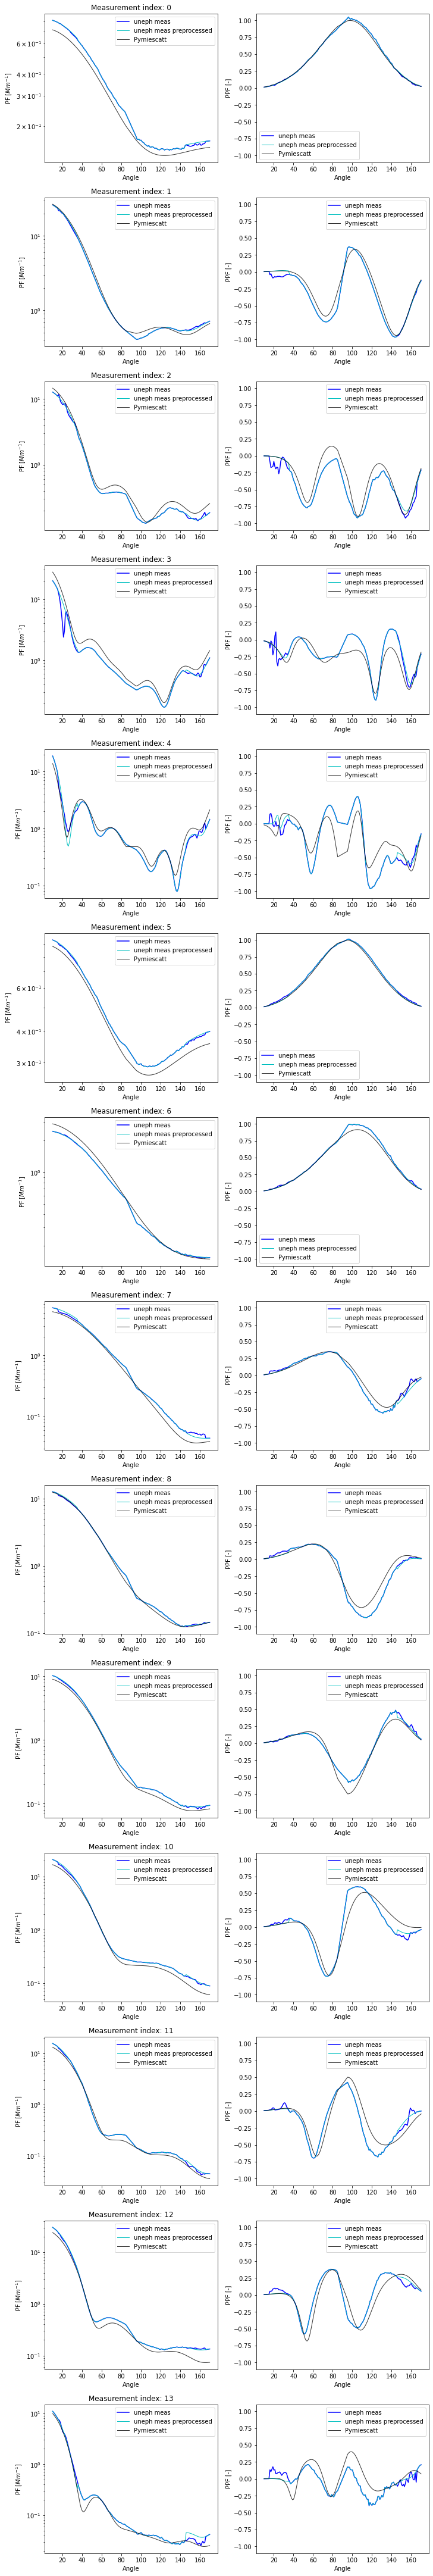

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [16]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.153705      3.085057      3.079462      3.058732      3.015831  ...   
2       2.402714      2.460123      2.361134      2.213312      2.163275  ...   
3       2.670581      2.528389      2.344447      2.093368      1.753163  ...   
4       2.251073      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.090018     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.864882      0.861694      0.855720      0.845499      0.832738  ...   
7       1.748572      1.647445      1.628860      1.612596      1.597519  ...   
8       2.473543      2.406455      2.388337      2.377311      2.366132  ...   
9       2.251546      2.210759      2.194205      2.171341      2.145541  ...   
10      2.937241      2.833671      2.811790      2.797430      2.768145  ...   
11      2.611837      2.534591      2.504700      2.456799      2.404771  ...   
12      3.223898      3.146513      3.119785      3.031482      2.951414  ...   
13      2.072779      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141       -0.50454      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497        0.06563       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791        0.03127   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364       -0.03792      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [17]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [18]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [19]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas[F11_columns_meas].values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0   0.853742  0.102581  1.062851  1.675137  0.052705
1   6.832774  0.218830  1.035375  1.856431  0.401491
2   2.023107  0.251867  1.066438  1.545646  0.044373
3   4.076245  0.481382  1.109497  1.720745  0.006064
4   5.907606  0.441930  1.046299  1.556496  0.011523
5   0.600719  0.089530  1.065602  2.258148  1.262545
6   1.712838  0.105859  1.072283  1.531737  0.206078
7   6.895063  0.176059  1.055223  1.353738  0.105951
8   6.108081  0.172584  1.096390  1.469406  0.182159
9   2.488819  0.192184  1.142095  1.563342  0.067107
10  4.709904  0.259174  1.097134  1.557297  0.204332
11  3.260513  0.275261  1.083305  1.551263  0.201210
12  6.335256  0.308313  1.066556  1.527300  0.118340
13  2.485004  0.379058  1.153361  1.474801  0.168301

In [20]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n         k
0  -0.158126  4.630654 -2.766982 -1.063815 -2.943048
1   1.921731  5.388295 -3.341760 -0.641635 -0.912570
2   0.704634  5.528903 -2.711491 -1.534119 -3.115127
3   1.405176  6.176662 -2.211858 -0.939701 -5.105342
4   1.776241  6.091151 -3.072636 -1.485028 -4.463433
5  -0.509627  4.494575 -2.724145 -0.074564  0.233129
6   0.538152  4.662104 -2.627164 -1.600791 -1.579499
7   1.930806  5.170822 -2.896377 -3.740693 -2.244782
8   1.809613  5.150883 -2.339352 -1.970364 -1.702873
9   0.911808  5.258453 -1.951256 -1.455251 -2.701461
10  1.549667  5.557500 -2.331666 -1.481496 -1.588007
11  1.181885  5.617720 -2.485250 -1.508402 -1.603404
12  1.846130  5.731117 -2.709706 -1.623028 -2.134189
13  0.910274  5.937690 -1.874958 -1.932392 -1.782001

In [21]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed[F11_columns_meas].values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0   0.712418  0.101956  1.067145  1.729706  0.043168
1   6.929482  0.215284  1.034756  1.931156  0.387762
2   1.899507  0.249983  1.053960  1.538842  0.039974
3   2.506708  0.341122  1.060217  1.758404  0.012236
4   7.529603  0.507128  1.083792  1.466947  0.008772
5   0.607384  0.089187  1.063689  2.625415  1.309750
6   1.812563  0.105015  1.070439  1.509436  0.198980
7   3.201636  0.154425  1.070834  1.571160  0.355966
8   5.105866  0.169921  1.143500  1.507760  0.125650
9   2.554037  0.189721  1.142728  1.585723  0.099825
10  4.643370  0.246528  1.079284  1.645088  0.209342
11  3.509784  0.274028  1.082505  1.550895  0.236463
12  6.414805  0.304071  1.064977  1.533166  0.123458
13  1.919054  0.387806  1.077093  1.442473  0.086424

In [22]:
F11_columns = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]

In [23]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt[F11_columns].values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0   0.895131  0.104659  1.044650  1.578342  0.076694
1   6.381223  0.228444  1.068499  2.421979  0.112643
2   2.195526  0.244912  1.062676  1.572911  0.023095
3   3.108776  0.330999  1.040381  1.598361  0.011072
4   9.861235  0.584363  1.053238  1.386390  0.010875
5   0.662069  0.089220  1.035560  1.799355  1.097598
6   1.818254  0.113454  1.085323  1.668283  0.193542
7   2.658197  0.147558  1.029292  1.601999  0.303826
8   5.877703  0.167715  1.063796  1.581189  0.306256
9   2.622136  0.188077  1.061563  1.582199  0.147452
10  3.660129  0.239120  1.092692  1.636493  0.141806
11  2.713360  0.250678  1.076869  1.665251  0.226211
12  4.775473  0.305169  1.064765  1.548471  0.214963
13  2.448789  0.395855  1.082796  1.569106  0.153695

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [24]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.708613  5.986968 -2.302585 -1.237874 -1.500584

In [25]:
F11_columns

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

In [26]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = F11_columns)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.638796  0.522248  0.630721  0.436768  0.500493  0.656269  0.486311   
1   3.425143  3.252456  3.137556  3.132672  3.148567  3.128015  3.060281   
2   2.578487  2.321918  2.161685  2.097811  2.118339  2.051282  1.901127   
3   2.495246  2.400102  2.365158  2.386870  2.367584  2.257658  2.151634   
4   2.704034  2.579987  2.470587  2.427446  2.371719  2.204396  2.034186   
5   0.076848  0.022078  0.049906  0.037720  0.080134  0.139852  0.099681   
6   1.005101  1.014597  1.008079  0.995610  0.989821  0.979908  0.978962   
7   1.628943  1.634179  1.622344  1.612257  1.603141  1.596216  1.589471   
8   2.489312  2.469694  2.458178  2.450235  2.440380  2.427062  2.406743   
9   2.187436  2.183713  2.173422  2.149544  2.138224  2.124972  2.104971   
10  2.794268  2.778140  2.746919  2.740534  2.706402  2.683605  2.657374   
11  2.578965  2.535098  2.510466  2.497867  2.472437  2.441784  2.415449   
12  3.139074  3.113302  3.094769  3.061037  3.019302  2.968445  2.933844   
13  2.305659  2.237922  2.188470  2.143370  2.075002  1.991780  1.914906   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.508260  0.261437  0.208698  ...  0.546174  0.490050  0.396978  0.436929   
1   2.971308  2.899696  2.797085  ... -0.213391 -0.248305 -0.192992 -0.172768   
2   1.683166  1.608830  1.498382  ... -0.763642 -0.790053 -0.689627 -0.698783   
3   2.035701  1.972282  1.861178  ...  0.011104  0.047594  0.188127  0.314167   
4   1.902549  1.791571  1.639619  ...  0.085680  0.117367  0.186059  0.293737   
5   0.080268  0.042702  0.007800  ... -0.054292 -0.024694 -0.027892  0.000507   
6   0.971212  0.961492  0.958888  ... -1.844032 -1.841557 -1.842511 -1.846356   
7   1.581397  1.567799  1.551027  ... -3.325280 -3.324875 -3.328108 -3.324521   
8   2.370133  2.355080  2.333599  ... -2.044809 -2.040814 -2.036030 -2.036577   
9   2.050724  2.042340  2.021696  ... -2.632212 -2.628049 -2.624322 -2.636209   
10  2.640458  2.621325  2.601826  ... -2.738927 -2.766450 -2.768759 -2.783473   
11  2.388028  2.344708  2.292154  ... -3.126630 -3.144696 -3.159654 -3.175785   
12  2.905470  2.850984  2.800956  ... -2.597606 -2.610748 -2.609253 -2.611152   
13  1.838226  1.745469  1.647173  ... -3.663156 -3.671106 -3.678150 -3.674733   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0   0.518818  0.542254  0.175598  0.266404  0.278943  0.601486  
1  -0.182927 -0.161780 -0.153933 -0.152985 -0.150981 -0.115561  
2  -0.729217 -0.668269 -0.672091 -0.651569 -0.631515 -0.551561  
3   0.438434  0.599014  0.703827  0.854797  1.018960  1.165124  
4   0.349148  0.488879  0.570717  0.709473  0.862689  1.035973  
5   0.068031  0.124400  0.059609  0.115476  0.136410  0.203292  
6  -1.838954 -1.846550 -1.843900 -1.837723 -1.838213 -1.839112  
7  -3.321074 -3.315583 -3.311798 -3.307527 -3.300720 -3.296502  
8  -2.044998 -2.033764 -2.035715 -2.037594 -2.033252 -2.035449  
9  -2.655363 -2.633485 -2.644119 -2.650615 -2.638783 -2.644091  
10 -2.797390 -2.804090 -2.817012 -2.820635 -2.832748 -2.838624  
11 -3.184211 -3.194203 -3.198290 -3.208247 -3.215721 -3.230291  
12 -2.604003 -2.592272 -2.578572 -2.578631 -2.553709 -2.553594  
13 -3.667730 -3.662408 -3.652141 -3.631758 -3.609691 -3.589843  

[14 rows x 152 columns]

In [27]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = F11_columns)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.186967  0.210543  0.192964  0.194621  0.186118  0.215343  0.223923   
1   3.373344  3.343965  3.328024  3.312053  3.284219  3.258372  3.245344   
2   2.629778  2.620271  2.602286  2.585725  2.555456  2.532750  2.518232   
3   2.885653  2.808428  2.736637  2.651871  2.540479  2.410020  2.291508   
4   3.641261  3.605573  3.563385  3.489680  3.379830  3.203706  3.067908   
5   0.353641  0.374030  0.373169  0.348143  0.299237  0.275456  0.259434   
6   0.245637  0.256430  0.256698  0.252939  0.253510  0.251827  0.246541   
7   2.313997  2.307751  2.299715  2.295099  2.287295  2.274248  2.266838   
8   2.521445  2.515740  2.502338  2.494415  2.483661  2.469892  2.457858   
9   2.334808  2.312992  2.298826  2.303175  2.290132  2.279635  2.261512   
10  3.083218  3.049906  3.023439  3.006023  2.979075  2.950747  2.925602   
11  2.766056  2.733391  2.711633  2.690522  2.659389  2.618541  2.591768   
12  3.772234  3.744128  3.721585  3.686042  3.643223  3.591453  3.558269   
13  2.653795  2.600833  2.530416  2.474351  2.414272  2.349615  2.272854   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.210175  0.187919  0.159033  ... -1.679621 -1.655016 -1.660695 -1.626330   
1   3.227380  3.198249  3.165781  ... -0.990880 -0.996283 -1.005463 -1.011493   
2   2.492218  2.452942  2.409987  ... -2.437062 -2.440976 -2.430431 -2.421493   
3   2.189476  2.075329  1.940698  ... -0.216088 -0.138607 -0.055917  0.058471   
4   2.975930  2.912008  2.803111  ... -0.148085 -0.171527 -0.208861 -0.202448   
5   0.261310  0.261236  0.260627  ... -0.843077 -0.850336 -0.850170 -0.844658   
6   0.239513  0.236360  0.231344  ... -1.647689 -1.636052 -1.630744 -1.622991   
7   2.252507  2.239657  2.224762  ... -2.474674 -2.452487 -2.440669 -2.430099   
8   2.440803  2.425023  2.406978  ... -2.059472 -2.044295 -2.033050 -2.020489   
9   2.238022  2.222795  2.201816  ... -1.874314 -1.867609 -1.852568 -1.838049   
10  2.894885  2.858011  2.809626  ... -2.690114 -2.708853 -2.723367 -2.742488   
11  2.569026  2.528735  2.483888  ... -3.057908 -3.068142 -3.079713 -3.096751   
12  3.533770  3.487658  3.446031  ... -2.272748 -2.291122 -2.305745 -2.320981   
13  2.193081  2.117916  2.037860  ... -3.834164 -3.854209 -3.879303 -3.898877   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.621046 -1.599027 -1.591855 -1.573809 -1.600230 -1.615024  
1  -1.016112 -1.026763 -1.034034 -1.043807 -1.051197 -1.066061  
2  -2.408116 -2.383817 -2.369056 -2.369188 -2.344449 -2.347000  
3   0.174129  0.308333  0.444867  0.597200  0.756006  0.918036  
4  -0.187077 -0.164721 -0.160054 -0.079209 -0.025149  0.059829  
5  -0.850286 -0.842839 -0.839109 -0.850927 -0.845108 -0.851543  
6  -1.609668 -1.606069 -1.598232 -1.587893 -1.590549 -1.590092  
7  -2.413751 -2.408395 -2.394131 -2.374927 -2.361216 -2.346171  
8  -2.009185 -1.997293 -1.987400 -1.978126 -1.966995 -1.961068  
9  -1.827755 -1.811908 -1.795698 -1.788122 -1.776175 -1.772046  
10 -2.754010 -2.767439 -2.775681 -2.785042 -2.795312 -2.807484  
11 -3.099026 -3.109574 -3.108770 -3.112226 -3.113633 -3.124950  
12 -2.322562 -2.325950 -2.317433 -2.321483 -2.299725 -2.307642  
13 -3.911869 -3.928661 -3.937036 -3.926939 -3.924465 -3.908303  

[14 rows x 152 columns]

In [28]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = F11_columns)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.315593  0.345690  0.325623  0.320158  0.295056  0.320506  0.328349   
1   3.403172  3.379498  3.363171  3.345403  3.317638  3.291886  3.278022   
2   2.565351  2.555170  2.536112  2.518553  2.487256  2.464676  2.453499   
3   2.405437  2.386102  2.348456  2.296258  2.257756  2.217925  2.165650   
4   3.923620  3.891575  3.817901  3.722978  3.592938  3.438923  3.280512   
5   0.502789  0.516921  0.514007  0.487839  0.436028  0.412157  0.395500   
6   0.204046  0.214842  0.214900  0.211304  0.211041  0.210341  0.204939   
7   1.825049  1.832093  1.825520  1.817621  1.808180  1.796972  1.788877   
8   2.548577  2.535542  2.528761  2.527557  2.514854  2.499553  2.487134   
9   2.325577  2.305809  2.297781  2.291982  2.280936  2.270381  2.251288   
10  3.121026  3.084098  3.054533  3.051963  3.020749  2.995190  2.963004   
11  2.767824  2.735778  2.713108  2.691323  2.659710  2.619667  2.592533   
12  3.765204  3.738272  3.723414  3.693506  3.651850  3.598119  3.566042   
13  2.768477  2.689905  2.612256  2.557441  2.495574  2.419324  2.346577   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.316367  0.287405  0.253473  ... -1.697575 -1.674925 -1.684366 -1.645462   
1   3.260308  3.231449  3.198742  ... -0.689374 -0.688756 -0.694136 -0.695050   
2   2.428365  2.387521  2.341187  ... -2.474638 -2.479353 -2.467724 -2.459371   
3   2.071947  2.006148  1.929516  ... -0.129321 -0.034155  0.095822  0.170233   
4   3.115455  2.974804  2.815751  ... -0.179543 -0.257523 -0.314309 -0.365300   
5   0.395265  0.390341  0.385450  ... -0.518865 -0.524635 -0.523267 -0.515880   
6   0.197650  0.194635  0.188670  ... -1.601278 -1.588303 -1.582410 -1.573438   
7   1.780417  1.765509  1.749243  ... -3.168125 -3.172901 -3.183617 -3.187466   
8   2.470801  2.458041  2.440480  ... -1.946069 -1.937327 -1.926648 -1.918332   
9   2.209721  2.197727  2.178590  ... -2.030946 -2.025261 -2.012675 -2.012898   
10  2.937826  2.905851  2.869672  ... -2.507588 -2.537084 -2.546166 -2.563431   
11  2.568380  2.527221  2.480320  ... -3.011433 -3.017199 -3.023884 -3.035942   
12  3.546870  3.502055  3.463278  ... -2.302166 -2.324261 -2.340884 -2.358438   
13  2.283681  2.219870  2.151215  ... -3.680731 -3.728993 -3.786925 -3.840282   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.647193 -1.628159 -1.617385 -1.606640 -1.640101 -1.662792  
1  -0.695800 -0.704065 -0.708152 -0.714862 -0.720165 -0.732551  
2  -2.447611 -2.422761 -2.411869 -2.415896 -2.391810 -2.397242  
3   0.305138  0.393397  0.502362  0.608698  0.680785  0.762890  
4  -0.409935 -0.453027 -0.475888 -0.484997 -0.473591 -0.435225  
5  -0.520787 -0.511055 -0.505739 -0.520248 -0.513728 -0.523258  
6  -1.559553 -1.553489 -1.546460 -1.536554 -1.539962 -1.541648  
7  -3.194167 -3.201810 -3.204344 -3.207601 -3.210798 -3.213937  
8  -1.905812 -1.894241 -1.882800 -1.873268 -1.861195 -1.854053  
9  -2.015106 -1.993460 -1.990138 -1.988079 -1.974185 -1.973036  
10 -2.578325 -2.588012 -2.599449 -2.606463 -2.621860 -2.630731  
11 -3.036481 -3.045204 -3.044434 -3.048132 -3.052065 -3.064984  
12 -2.362297 -2.366689 -2.358715 -2.365604 -2.343251 -2.353529  
13 -3.874971 -3.929899 -3.951329 -3.948984 -3.961118 -3.943912  

[14 rows x 152 columns]

In [29]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = F11_columns)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.059769 -0.016224 -0.035294 -0.052030 -0.093661 -0.080260 -0.074960   
1   2.860698  2.833256  2.801174  2.755954  2.711527  2.680931  2.642458   
2   2.802918  2.798604  2.778632  2.751107  2.719078  2.696612  2.692820   
3   3.301455  3.287489  3.275551  3.237268  3.194198  3.134732  3.080728   
4   4.148542  4.116554  4.000083  3.848943  3.647127  3.439633  3.198918   
5   0.019638  0.030992  0.005750 -0.028611 -0.089706 -0.103626 -0.118989   
6   0.898901  0.913166  0.911412  0.903909  0.903092  0.898059  0.896715   
7   1.700363  1.711640  1.703814  1.689850  1.676266  1.668613  1.666700   
8   2.632292  2.626063  2.611923  2.603328  2.591719  2.575687  2.561479   
9   2.217384  2.191568  2.168311  2.164261  2.152180  2.141734  2.126566   
10  3.015314  2.980477  2.951620  2.937616  2.905819  2.881645  2.856050   
11  2.596709  2.551740  2.524513  2.520912  2.493044  2.466572  2.437127   
12  3.216115  3.187076  3.172825  3.139774  3.094830  3.039791  3.006682   
13  2.634347  2.556069  2.498117  2.454626  2.392256  2.314503  2.242898   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.087042 -0.113157 -0.146084  ... -1.919978 -1.917030 -1.909676 -1.880157   
1   2.598458  2.556323  2.499086  ... -0.032450  0.013052  0.054874  0.103077   
2   2.675000  2.635374  2.595948  ... -1.720938 -1.707855 -1.685507 -1.667556   
3   3.043261  2.993683  2.947947  ... -0.608070 -0.571146 -0.531716 -0.508003   
4   2.905096  2.700298  2.496194  ... -0.290942 -0.426218 -0.489347 -0.616751   
5  -0.122969 -0.133254 -0.142442  ... -1.065346 -1.081926 -1.069155 -1.059961   
6   0.890202  0.883037  0.881012  ... -1.753448 -1.749459 -1.749516 -1.750525   
7   1.662922  1.644591  1.625905  ... -4.038373 -4.058703 -4.082761 -4.099743   
8   2.544399  2.525138  2.504150  ... -1.960943 -1.950721 -1.945829 -1.935423   
9   2.096203  2.079937  2.059274  ... -2.053889 -2.052094 -2.047901 -2.046056   
10  2.826744  2.794371  2.756846  ... -2.507802 -2.530645 -2.535098 -2.543930   
11  2.411858  2.375604  2.333424  ... -2.963062 -2.989446 -3.001941 -3.018747   
12  2.985334  2.933838  2.884922  ... -2.809920 -2.828210 -2.833229 -2.840709   
13  2.171776  2.086305  1.991206  ... -3.367162 -3.397704 -3.430038 -3.451682   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.884296 -1.849159 -1.847835 -1.853994 -1.869458 -1.896241  
1   0.143857  0.192164  0.225763  0.259571  0.298571  0.332038  
2  -1.642401 -1.608252 -1.588871 -1.583210 -1.548486 -1.547370  
3  -0.448854 -0.428221 -0.365713 -0.314761 -0.280250 -0.231347  
4  -0.724215 -0.873099 -0.985574 -1.141626 -1.261701 -1.359268  
5  -1.067414 -1.040104 -1.030060 -1.044539 -1.022950 -1.025286  
6  -1.741458 -1.746897 -1.741171 -1.733399 -1.733297 -1.731522  
7  -4.110924 -4.126033 -4.132594 -4.138872 -4.142681 -4.145415  
8  -1.931621 -1.927544 -1.920587 -1.915351 -1.910773 -1.908455  
9  -2.050603 -2.043116 -2.044809 -2.050172 -2.046439 -2.058720  
10 -2.550039 -2.548196 -2.550609 -2.555694 -2.555699 -2.559966  
11 -3.032308 -3.043298 -3.052301 -3.061739 -3.075547 -3.087352  
12 -2.841498 -2.837597 -2.829655 -2.836105 -2.816177 -2.823009  
13 -3.466085 -3.484884 -3.488601 -3.474288 -3.460104 -3.437165  

[14 rows x 152 columns]

In [30]:
np.exp(qoi_meas_pred)

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0    1.205588   1.234349   1.212839   1.214851   1.204565   1.240287   
1   29.175920  28.331249  27.883188  27.441416  26.688130  26.007166   
2   13.870685  13.739449  13.494555  13.272906  12.877165  12.588078   
3   17.915261  16.583823  15.434989  14.180541  12.685746  11.134186   
4   38.139889  36.802768  35.282443  32.775466  29.365771  24.623616   
5    1.424244   1.453580   1.452330   1.416435   1.348829   1.317131   
6    1.278436   1.292308   1.292655   1.287805   1.288540   1.286373   
7   10.114768  10.051789   9.971340   9.925419   9.848261   9.720605   
8   12.446574  12.375761  12.211010  12.114640  11.985061  11.821170   
9   10.327475  10.104614   9.962483  10.005898   9.876242   9.773114   
10  21.828543  21.113352  20.561881  20.206877  19.669605  19.120237   
11  15.895820  15.384974  15.053845  14.739365  14.287562  13.715704   
12  43.477083  42.272133  41.329841  39.886664  38.214821  36.286759   
13  14.207859  13.474959  12.558733  11.873997  11.181627  10.481531   

       F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0    1.250974   1.233895   1.206735   1.172377  ...  0.186445  0.191089   
1   25.670532  25.213522  24.489621  23.707261  ...  0.371250  0.369249   
2   12.406643  12.088060  11.622495  11.133819  ...  0.087417  0.087076   
3    9.889835   8.930534   7.967164   6.963609  ...  0.805664  0.870570   
4   21.496893  19.607851  18.393694  16.495879  ...  0.862358  0.842378   
5    1.296196   1.298630   1.298534   1.297743  ...  0.430384  0.427271   
6    1.279592   1.270630   1.266630   1.260293  ...  0.192494  0.194747   
7    9.648842   9.511555   9.390112   9.251278  ...  0.084190  0.086079   
8   11.679768  11.482256  11.302492  11.100364  ...  0.127521  0.129471   
9    9.597588   9.374765   9.233101   9.041413  ...  0.153460  0.154493   
10  18.645443  18.081415  17.426825  16.603704  ...  0.067873  0.066613   
11  13.353355  13.053110  12.537642  11.987782  ...  0.046986  0.046507   
12  35.102365  34.252852  32.709253  31.375600  ...  0.103029  0.101153   
13   9.707061   8.962789   8.313793   7.674172  ...  0.021619  0.021190   

     F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0   0.190007  0.196650  0.197692  0.202093  0.203548  0.207254  0.201850   
1   0.365875  0.363675  0.362000  0.358164  0.355570  0.352112  0.349519   
2   0.087999  0.088789  0.089985  0.092198  0.093569  0.093557  0.095900   
3   0.945617  1.060215  1.190209  1.361154  1.560283  1.817023  2.129753   
4   0.811508  0.816729  0.829380  0.848130  0.852097  0.923847  0.975165   
5   0.427342  0.429704  0.427293  0.430487  0.432095  0.427019  0.429511   
6   0.195784  0.197308  0.199954  0.200675  0.202254  0.204356  0.203814   
7   0.087103  0.088028  0.089479  0.089960  0.091252  0.093021  0.094306   
8   0.130936  0.132591  0.134098  0.135702  0.137051  0.138328  0.139877   
9   0.156834  0.159128  0.160774  0.163342  0.166011  0.167274  0.169284   
10  0.065653  0.064410  0.063672  0.062823  0.062307  0.061726  0.061096   
11  0.045972  0.045196  0.045093  0.044620  0.044656  0.044502  0.044439   
12  0.099684  0.098177  0.098022  0.097691  0.098526  0.098128  0.100286   
13  0.020665  0.020265  0.020003  0.019670  0.019506  0.019704  0.019753   

     F11_170  
0   0.198886  
1   0.344362  
2   0.095656  
3   2.504367  
4   1.061654  
5   0.426756  
6   0.203907  
7   0.095735  
8   0.140708  
9   0.169985  
10  0.060357  
11  0.043939  
12  0.099496  
13  0.020075  

[14 rows x 152 columns]

In [31]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

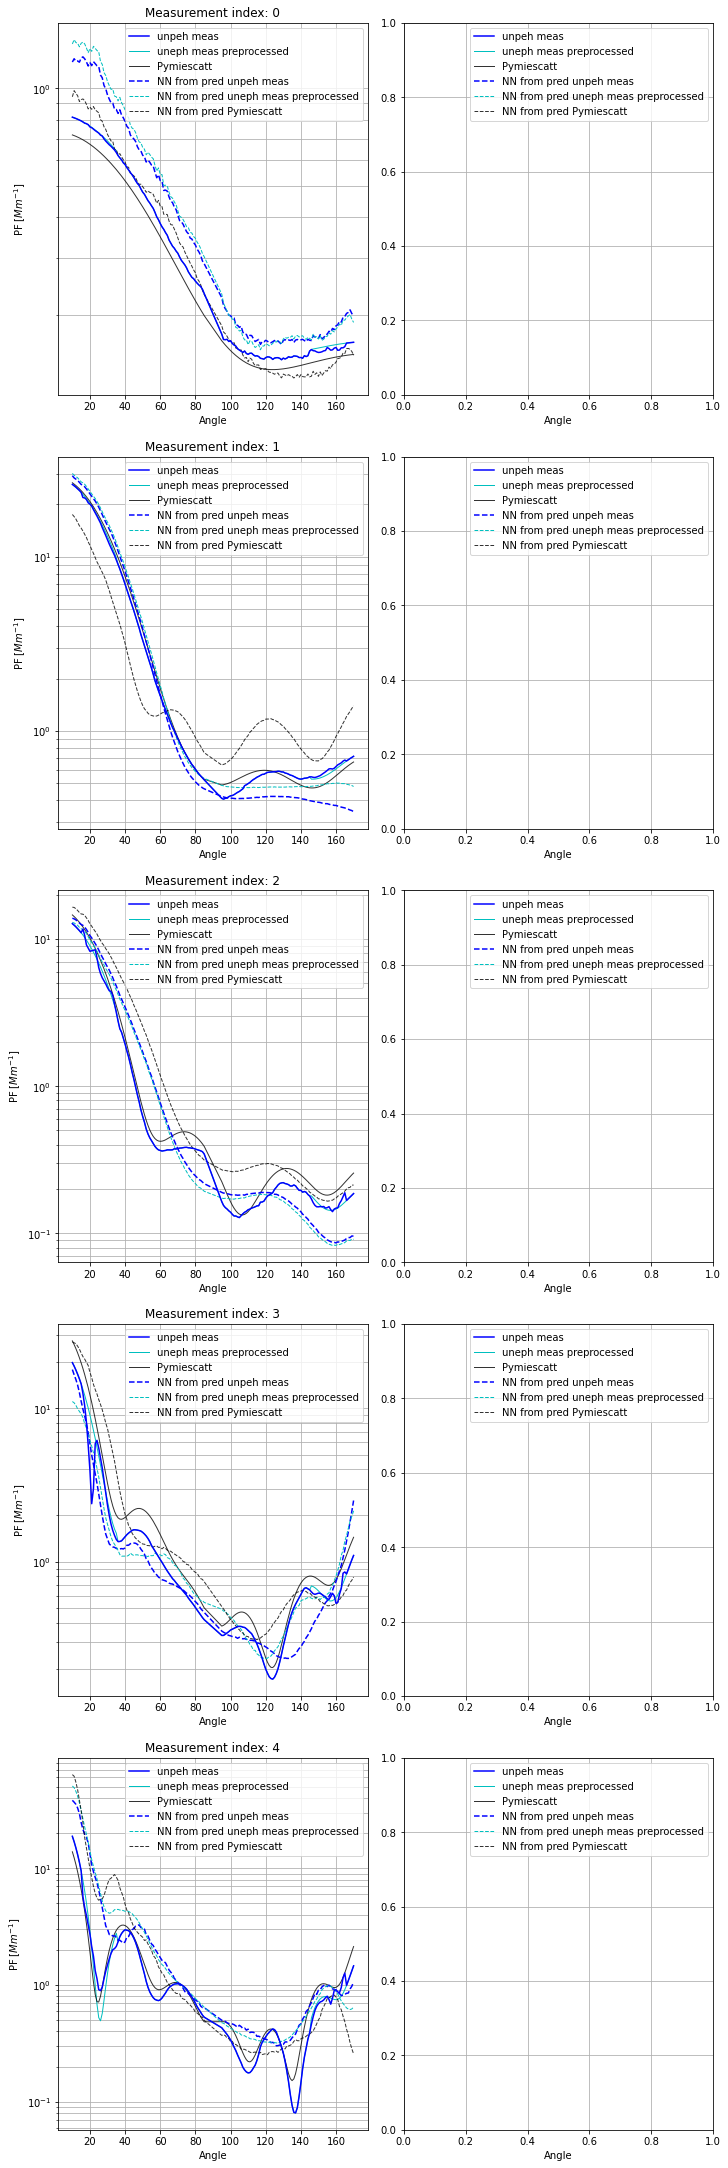

In [32]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


In [33]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [32]:
D_array = np.logspace(0.1, 5, 300)

In [33]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [34]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [35]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
#pms_qoi_meas_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

202.88808120982085
191.99816991290248
436.0758667064427
156.51303159797698
497.5208068977766
30.79642567316568
932.0804027123563
9.158017266171404
878.4451199698045
16.491713788366898
176.90459186569936
203.50045315570472
208.64592258352923
352.3457565748942
349.0799142829581
305.57544760921246
336.5090497547866
294.69057695485526
364.54162111865134
90.62614618346997
505.15551671260084
67.13416854401011
540.0487863751425
38.412764576780084
608.9941028010148
52.57897528313979
713.2011194022656
11.937318964333686


In [36]:

# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

201.34495236917604
163.55371239682765
429.0618337612441
166.67144680834886
495.84056422750547
29.391271153894248
675.2822834306348
15.309706009510188
994.7441507282172
14.190095772359633
176.34547460397903
207.93211900223218
207.13153576843405
381.5054336852252
304.54046939282006
211.97507007268837
321.99502558351463
269.39064650601233
359.7110249345556
96.73409533149852
484.52022454575496
75.94898618730511
537.8189163353584
41.888090059261344
600.9541314422478
55.45180187834887
762.8839694405453
8.052565365214969


In [37]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

208.1235590245289
188.01623277974932
450.91037078234535
130.33340545448462
484.4237365528072
36.277848227433466
658.8925473753627
20.610299114874806
1159.3300622424035
11.941351154411292
177.78823368554956
223.7739476067496
222.39102201276395
306.33921635185703
294.37905511868104
198.2616887807497
331.60370620894463
302.605154173939
372.1477294812691
95.61699697116462
467.0977770996087
66.20908266363769
493.1746051242124
42.149065825890496
603.1695748390518
40.832230274297146
776.8227202703099
9.69662602085054


In [34]:
# Calculate relative error for aerosol retrieval

def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

Vtot           49.066653
RmedianV        9.449312
GSD             2.332373
n               9.435640
k           36882.853132
dtype: float64
Vtot           38.208581
RmedianV        6.953145
GSD             2.086735
n              11.062195
k           35156.186716
dtype: float64
Vtot           34.661197
RmedianV        7.736922
GSD             1.469038
n               7.051831
k           16747.503639
dtype: float64


In [37]:
qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')

<ipython-input-37-867fea1fd93e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')


In [38]:
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])

In [39]:
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)


In [40]:
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4

Vtot  RmedianV   GSD      n          k
meas_vs_pred               41.82     12.71  2.23   7.05  103131.18
meas_vs_preprocessed_pred  52.95      9.86  1.73  10.36   98282.39
meas_vs_pymiescatt_pred    58.21     13.25  0.93  13.49   46775.93

In [41]:
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

Vtot  RmedianV   GSD      n      k
meas_vs_pred               53.09      7.64  2.39  10.76  78.23
meas_vs_preprocessed_pred  30.02      5.34  2.29  11.45  86.07
meas_vs_pymiescatt_pred    21.58      4.67  1.77   3.47  65.04

In [42]:
rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

F11  PPF
meas_vs_pred                    74.13  NaN
meas_vs_meas_pred               43.08  NaN
meas_vs_meas_preprocessed_pred  44.59  NaN
meas_vs_meas_pymiescatt_pred    59.88  NaN

In [43]:
rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13

F11  PPF
meas_vs_pred                    16.40  NaN
meas_vs_meas_pred               30.39  NaN
meas_vs_meas_preprocessed_pred  28.78  NaN
meas_vs_meas_pymiescatt_pred    17.55  NaN

In [44]:
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')